<a href="https://colab.research.google.com/github/Saurabhrai08/ANN_PROJECT/blob/main/animal_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install rarfile

In [ ]:
import rarfile
import os

# Specify the path to your rar file
rar_path = '/content/drive/MyDrive/animal_data.rar' # Assuming it's in the root of your Drive

# Specify the directory where you want to extract the contents
extract_path = '/content/'

# Check if the file exists
if os.path.exists(rar_path):
    try:
        # Open the rar file
        with rarfile.RarFile(rar_path, 'r') as rf:
            # Extract all the contents into the specified directory
            rf.extractall(extract_path)
        print(f"Successfully extracted {rar_path} to {extract_path}")
    except rarfile.BadRarFile:
        print(f"Error: {rar_path} is not a valid rar file.")
    except FileNotFoundError:
        print(f"Error: The file {rar_path} was not found.")
    except Exception as e:
        print(f"An error occurred: {e}")
else:
    print(f"Error: The file {rar_path} does not exist.")

Successfully extracted /content/drive/MyDrive/animal_data.rar to /content/


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import timm # PyTorch Image Models
import numpy as np
import matplotlib.pyplot as plt
import os
import random
from torch.utils.data import Dataset, DataLoader
from PIL import Image

In [ ]:
import os

# List the contents of the extraction directory (assuming it was /content/)
extracted_contents = os.listdir('/content/')
print("Contents of /content/ after extraction:")
print(extracted_contents)

# You should see your extracted dataset folders here.
# Identify the folder names for your cow and buffalo images.
# For example, if you see 'Indian_bovine_breeds' and 'buffalo_images',
# you will use these names in the next steps.

Contents of /content/ after extraction:
['.config', 'buffalo', 'Indian_bovine_breeds', 'drive', 'sample_data']


In [ ]:
import os

# Define the base directory where the data was extracted
base_dir = '/content/' # Or the path you used for extraction

# Define the names of the class folders
cow_folder = 'Indian_bovine_breeds'
buffalo_folder = 'buffalo'

# Create lists to store image paths and labels
image_paths = []
labels = []

# Function to collect image paths and assign labels
def collect_images(folder_path, label):
    for root, _, files in os.walk(folder_path):
        for file in files:
            # Assuming image files have common extensions, you might want to filter
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
                image_paths.append(os.path.join(root, file))
                labels.append(label)

# Collect images and labels for cow and buffalo
collect_images(os.path.join(base_dir, cow_folder), 'cow')
collect_images(os.path.join(base_dir, buffalo_folder), 'buffalo')

# Print the number of images found for each class
print(f"Found {labels.count('cow')} cow images.")
print(f"Found {labels.count('buffalo')} buffalo images.")
print(f"Total images found: {len(image_paths)}")

# You can also inspect the first few paths and labels
# print("\nFirst 5 image paths:")
# print(image_paths[:5])
# print("\nFirst 5 labels:")
# print(labels[:5])

Found 5042 cow images.
Found 2784 buffalo images.
Total images found: 7826


In [ ]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets first
train_paths, test_paths, train_labels, test_labels = train_test_split(
    image_paths, labels, test_size=0.2, random_state=42, stratify=labels
)

# Now split the training set into training and validation sets
train_paths, val_paths, train_labels, val_labels = train_test_split(
    train_paths, train_labels, test_size=0.15 / 0.85, random_state=42, stratify=train_labels
)

print(f"Training set size: {len(train_paths)}")
print(f"Validation set size: {len(val_paths)}")
print(f"Testing set size: {len(test_paths)}")

# You can also check the distribution of classes in each set
# from collections import Counter
# print("\nTraining set class distribution:", Counter(train_labels))
# print("Validation set class distribution:", Counter(val_labels))
# print("Testing set class distribution:", Counter(test_labels))

Training set size: 5155
Validation set size: 1105
Testing set size: 1566


In [ ]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms

# Define transformations for training with augmentation
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)), # Resize images to ViT input size
    transforms.RandomHorizontalFlip(), # Data augmentation
    transforms.RandomRotation(10), # Data augmentation
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), # Data augmentation
    transforms.ToTensor(), # Convert image to PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Normalize with ImageNet stats
])

# Define transformations for validation and testing (no augmentation)
val_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)), # Resize images to ViT input size
    transforms.ToTensor(), # Convert image to PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Normalize with ImageNet stats
])

# Create a dictionary to map labels to integers
label_map = {'cow': 0, 'buffalo': 1}

# Define a custom Dataset class
class AnimalDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]

        image = Image.open(img_path).convert('RGB') # Open image and ensure it's RGB

        if self.transform:
            image = self.transform(image)

        # Convert label to integer using the label_map
        label = label_map[label]

        return image, label

# Create Dataset instances
train_dataset = AnimalDataset(train_paths, train_labels, transform=train_transforms)
val_dataset = AnimalDataset(val_paths, val_labels, transform=val_test_transforms)
test_dataset = AnimalDataset(test_paths, test_labels, transform=val_test_transforms)

# Define DataLoader instances
batch_size = 32  # You can adjust the batch size
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("Dataset and DataLoader instances created.")

Dataset and DataLoader instances created.


In [ ]:
import timm
import torch.nn as nn

# Load a pre-trained Vision Transformer model
# 'vit_base_patch16_224' is a common choice, you can explore others in timm
model = timm.create_model('vit_base_patch16_224', pretrained=True)

# Modify the classifier head for your specific task
# The number of input features to the classifier is the output dimension of the ViT's last layer
num_ftrs = model.head.in_features

# Replace the head with a new one for 2 classes (cow and buffalo)
model.head = nn.Linear(num_ftrs, 2)

print("Pre-trained ViT model loaded and classifier head modified.")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Pre-trained ViT model loaded and classifier head modified.


In [ ]:
import torch.optim as optim
import torch.nn as nn

# Define the loss function
# CrossEntropyLoss is suitable for multi-class classification (which includes binary)
criterion = nn.CrossEntropyLoss()

# Define the optimizer
# AdamW is a common choice for training transformers
optimizer = optim.AdamW(model.parameters(), lr=1e-4) # You can adjust the learning rate

In [ ]:
# Determine the device to use (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Move the model to the selected device
model.to(device)

# Define the number of training epochs
num_epochs = 10 # You can adjust this number

# Early Stopping Parameters
patience = 3 # Number of epochs to wait for improvement
best_val_loss = float('inf')
epochs_no_improve = 0
early_stop = False

# Training and Validation Loop
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    if early_stop:
        print("Early stopping triggered.")
        break

    # Training Phase
    model.train() # Set the model to training mode
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        # Move images and labels to the device
        images, labels = images.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_train_loss = running_loss / len(train_dataset)
    epoch_train_accuracy = correct_train / total_train
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_accuracy)

    # Validation Phase
    model.eval() # Set the model to evaluation mode
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad(): # Disable gradient calculation during validation
        for images, labels in val_loader:
            # Move images and labels to the device
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    epoch_val_loss = running_val_loss / len(val_dataset)
    epoch_val_accuracy = correct_val / total_val
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_accuracy:.4f}, Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_accuracy:.4f}")

    # Early Stopping Check
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        epochs_no_improve = 0
        # Optionally save the best model state
        # torch.save(model.state_dict(), 'best_model.pth')
        # print("Saved best model state.")
    else:
        epochs_no_improve += 1
        if epochs_no_improve == patience:
            early_stop = True

print("Training finished.")

Using device: cuda
Epoch 1/10 - Train Loss: 0.2112, Train Acc: 0.9214, Val Loss: 0.1616, Val Acc: 0.9439
Epoch 2/10 - Train Loss: 0.1530, Train Acc: 0.9439, Val Loss: 0.1256, Val Acc: 0.9575
Epoch 3/10 - Train Loss: 0.1234, Train Acc: 0.9562, Val Loss: 0.1638, Val Acc: 0.9502
Epoch 4/10 - Train Loss: 0.1130, Train Acc: 0.9610, Val Loss: 0.1514, Val Acc: 0.9412
Epoch 5/10 - Train Loss: 0.0949, Train Acc: 0.9709, Val Loss: 0.1340, Val Acc: 0.9593
Early stopping triggered.
Training finished.


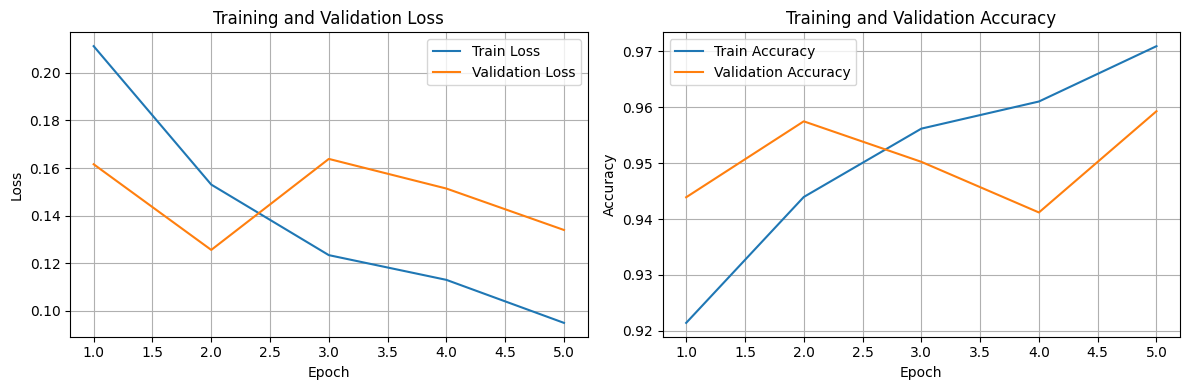

In [ ]:
import matplotlib.pyplot as plt

# Get the actual number of epochs completed
actual_epochs = len(train_losses)

# Plot training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, actual_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, actual_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, actual_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, actual_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
import torch

# Define the path to save the model state dictionary
model_save_path = 'animal_classifier.pth'

# Save the model's state dictionary
torch.save(model.state_dict(), model_save_path)

print(f"Model state dictionary saved to {model_save_path}")

Model state dictionary saved to animal_classifier.pth


In [ ]:
from google.colab import files

# Specify the path to the file you want to download
file_to_download = 'animal_classifier.pth'

# Check if the file exists before attempting to download
if os.path.exists(file_to_download):
  files.download(file_to_download)
else:
  print(f"Error: The file {file_to_download} was not found.")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Test Accuracy: 0.9559

Classification Report:
              precision    recall  f1-score   support

         cow       0.98      0.95      0.97      1009
     buffalo       0.92      0.96      0.94       557

    accuracy                           0.96      1566
   macro avg       0.95      0.96      0.95      1566
weighted avg       0.96      0.96      0.96      1566


Confusion Matrix:
[[962  47]
 [ 22 535]]


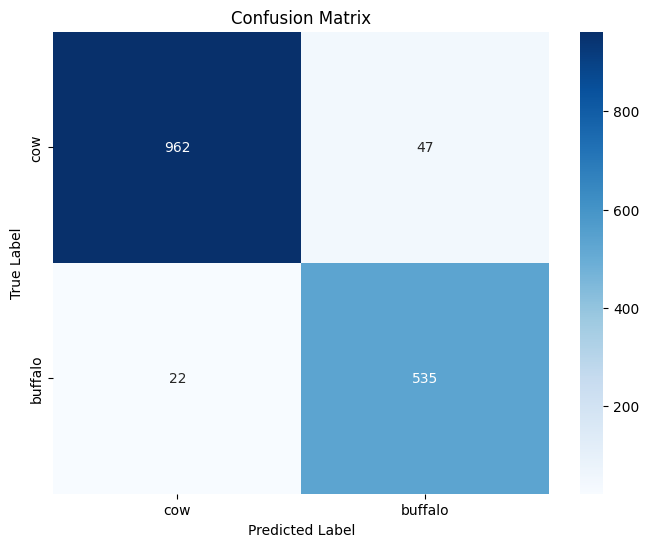

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch

# Set the model to evaluation mode
model.eval()

# Lists to store true labels and predicted labels
all_true_labels = []
all_predicted_labels = []

# Move model to the device if not already there
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Disable gradient calculation for evaluation
with torch.no_grad():
    for images, labels in test_loader:
        # Move images and labels to the device
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)

        # Get predicted class indices
        _, predicted = torch.max(outputs.data, 1)

        # Append true and predicted labels to the lists
        all_true_labels.extend(labels.cpu().numpy()) # Move labels back to CPU for scikit-learn
        all_predicted_labels.extend(predicted.cpu().numpy()) # Move predictions back to CPU

# Calculate Accuracy
accuracy = accuracy_score(all_true_labels, all_predicted_labels)
print(f"Test Accuracy: {accuracy:.4f}")

# Generate Classification Report
# We need the target names (cow, buffalo) corresponding to the integer labels (0, 1)
target_names = ['cow', 'buffalo'] # Ensure this order matches your label_map {'cow': 0, 'buffalo': 1}
print("\nClassification Report:")
print(classification_report(all_true_labels, all_predicted_labels, target_names=target_names))

# Generate Confusion Matrix
conf_matrix = confusion_matrix(all_true_labels, all_predicted_labels)

print("\nConfusion Matrix:")
print(conf_matrix)

# Visualize Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

CNN MODEL

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import os
import random
from torch.utils.data import Dataset, DataLoader
from PIL import Image

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

# Define a simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(SimpleCNN, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1) # Input channels = 3 (RGB), Output channels = 32
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1) # Input channels = 32, Output channels = 64

        # Pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) # Reduces spatial dimensions

        # Fully connected layers
        # The size of the input to the first fully connected layer depends on the output size of the last pooling layer
        # We'll need to calculate this size. Assuming input image size is 224x224 after transformations:
        # After conv1 and pool1: (224/2) x (224/2) = 112 x 112, 32 channels
        # After conv2 and pool2: (112/2) x (112/2) = 56 x 56, 64 channels
        self.fc1 = nn.Linear(64 * 56 * 56, 128) # Input features, Output features
        self.fc2 = nn.Linear(128, num_classes) # Output features = number of classes

        # Dropout layer for regularization
        self.dropout = nn.Dropout(0.5)


    def forward(self, x):
        # Apply convolutional and pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))

        # Flatten the output for the fully connected layers
        x = x.view(-1, 64 * 56 * 56) # -1 infers the batch size

        # Apply fully connected layers with dropout
        x = F.relu(self.fc1(x))
        x = self.dropout(x) # Apply dropout
        x = self.fc2(x) # Output layer

        return x

In [ ]:
# Create an instance of the CNN model
cnn_model = SimpleCNN(num_classes=2)

print("Simple CNN model architecture defined and instantiated.")

Simple CNN model architecture defined and instantiated.


In [ ]:
import torch.optim as optim
import torch.nn as nn

# Define the loss function for the CNN
# CrossEntropyLoss is suitable for multi-class classification
cnn_criterion = nn.CrossEntropyLoss()

# Define the optimizer for the CNN
# Adam is a common choice for CNNs
cnn_optimizer = optim.Adam(cnn_model.parameters(), lr=1e-4) # You can adjust the learning rate

In [ ]:
# Determine the device to use (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Move the CNN model to the selected device
cnn_model.to(device)

# Define the number of training epochs
cnn_num_epochs = 20 # You can adjust this number

# Early Stopping Parameters for CNN (optional, but good practice)
cnn_patience = 3 # Number of epochs to wait for improvement
cnn_best_val_loss = float('inf')
cnn_epochs_no_improve = 0
cnn_early_stop = False

# Training and Validation Loop for CNN
cnn_train_losses = []
cnn_val_losses = []
cnn_train_accuracies = []
cnn_val_accuracies = []

for epoch in range(cnn_num_epochs):
    if cnn_early_stop:
        print("CNN Early stopping triggered.")
        break

    # Training Phase
    cnn_model.train() # Set the model to training mode
    cnn_running_loss = 0.0
    cnn_correct_train = 0
    cnn_total_train = 0

    for images, labels in train_loader:
        # Move images and labels to the device
        images, labels = images.to(device), labels.to(device)

        # Zero the parameter gradients
        cnn_optimizer.zero_grad()

        # Forward pass
        outputs = cnn_model(images)
        loss = cnn_criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        cnn_optimizer.step()

        cnn_running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        cnn_total_train += labels.size(0)
        cnn_correct_train += (predicted == labels).sum().item()

    cnn_epoch_train_loss = cnn_running_loss / len(train_dataset)
    cnn_epoch_train_accuracy = cnn_correct_train / cnn_total_train
    cnn_train_losses.append(cnn_epoch_train_loss)
    cnn_train_accuracies.append(cnn_epoch_train_accuracy)

    # Validation Phase
    cnn_model.eval() # Set the model to evaluation mode
    cnn_running_val_loss = 0.0
    cnn_correct_val = 0
    cnn_total_val = 0

    with torch.no_grad(): # Disable gradient calculation during validation
        for images, labels in val_loader:
            # Move images and labels to the device
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = cnn_model(images)
            loss = cnn_criterion(outputs, labels)

            cnn_running_val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            cnn_total_val += labels.size(0)
            cnn_correct_val += (predicted == labels).sum().item()

    cnn_epoch_val_loss = cnn_running_val_loss / len(val_dataset)
    cnn_epoch_val_accuracy = cnn_correct_val / cnn_total_val
    cnn_val_losses.append(cnn_epoch_val_loss)
    cnn_val_accuracies.append(cnn_epoch_val_accuracy)

    print(f"CNN Epoch {epoch+1}/{cnn_num_epochs} - Train Loss: {cnn_epoch_train_loss:.4f}, Train Acc: {cnn_epoch_train_accuracy:.4f}, Val Loss: {cnn_epoch_val_loss:.4f}, Val Acc: {cnn_epoch_val_accuracy:.4f}")

    # Early Stopping Check
    if cnn_epoch_val_loss < cnn_best_val_loss:
        cnn_best_val_loss = cnn_epoch_val_loss
        cnn_epochs_no_improve = 0
        # Optionally save the best CNN model state
        # torch.save(cnn_model.state_dict(), 'best_cnn_model.pth')
        # print("Saved best CNN model state.")
    else:
        cnn_epochs_no_improve += 1
        if cnn_epochs_no_improve == cnn_patience:
            cnn_early_stop = True

print("CNN Training finished.")

Using device: cuda
CNN Epoch 1/20 - Train Loss: 0.5033, Train Acc: 0.7785, Val Loss: 0.4813, Val Acc: 0.7964
CNN Epoch 2/20 - Train Loss: 0.4088, Train Acc: 0.8169, Val Loss: 0.4124, Val Acc: 0.8208
CNN Epoch 3/20 - Train Loss: 0.3832, Train Acc: 0.8339, Val Loss: 0.3819, Val Acc: 0.8471
CNN Epoch 4/20 - Train Loss: 0.3721, Train Acc: 0.8448, Val Loss: 0.3732, Val Acc: 0.8471
CNN Epoch 5/20 - Train Loss: 0.3586, Train Acc: 0.8510, Val Loss: 0.3733, Val Acc: 0.8489
CNN Epoch 6/20 - Train Loss: 0.3535, Train Acc: 0.8510, Val Loss: 0.3614, Val Acc: 0.8471
CNN Epoch 7/20 - Train Loss: 0.3505, Train Acc: 0.8563, Val Loss: 0.3606, Val Acc: 0.8498
CNN Epoch 8/20 - Train Loss: 0.3274, Train Acc: 0.8629, Val Loss: 0.3479, Val Acc: 0.8606
CNN Epoch 9/20 - Train Loss: 0.3263, Train Acc: 0.8671, Val Loss: 0.3599, Val Acc: 0.8525
CNN Epoch 10/20 - Train Loss: 0.3167, Train Acc: 0.8632, Val Loss: 0.3426, Val Acc: 0.8661
CNN Epoch 11/20 - Train Loss: 0.3153, Train Acc: 0.8660, Val Loss: 0.3495, Val A

In [ ]:
import torch
import os

# Define the path to save the CNN model state dictionary
cnn_model_save_path = 'simple_cnn_model.pth' # Or choose a different name

# Save the CNN model's state dictionary
torch.save(cnn_model.state_dict(), cnn_model_save_path)

print(f"CNN model state dictionary saved to {cnn_model_save_path}")

CNN model state dictionary saved to simple_cnn_model.pth


In [ ]:
from google.colab import files
import os # Import os to check if the file exists

# Specify the path to the file you want to download
file_to_download = 'simple_cnn_model.pth'

# Check if the file exists before attempting to download
if os.path.exists(file_to_download):
  files.download(file_to_download)
else:
  print(f"Error: The file {file_to_download} was not found.")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

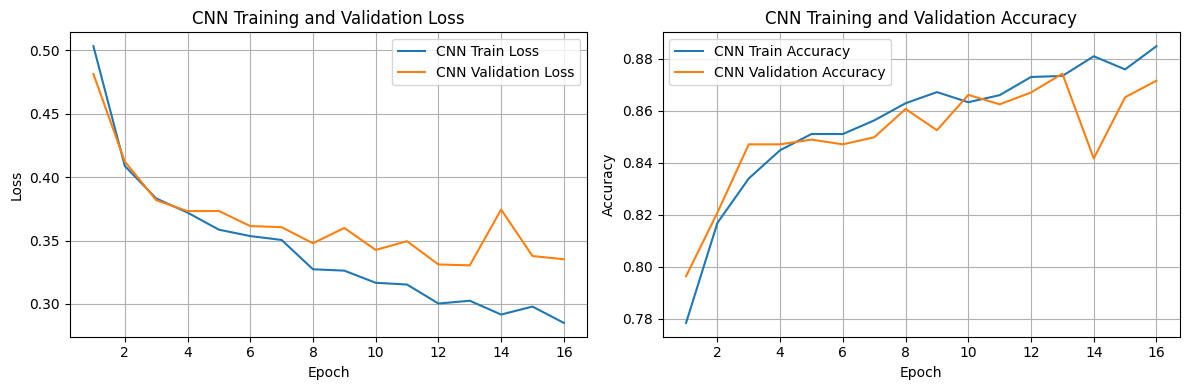

In [ ]:
import matplotlib.pyplot as plt

# Get the actual number of epochs completed for CNN training
cnn_actual_epochs = len(cnn_train_losses)

# Plot training and validation loss for CNN
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, cnn_actual_epochs + 1), cnn_train_losses, label='CNN Train Loss')
plt.plot(range(1, cnn_actual_epochs + 1), cnn_val_losses, label='CNN Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('CNN Training and Validation Loss')
plt.legend()
plt.grid(True)

# Plot training and validation accuracy for CNN
plt.subplot(1, 2, 2)
plt.plot(range(1, cnn_actual_epochs + 1), cnn_train_accuracies, label='CNN Train Accuracy')
plt.plot(range(1, cnn_actual_epochs + 1), cnn_val_accuracies, label='CNN Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('CNN Training and Validation Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


CNN Test Accuracy: 0.8799

CNN Classification Report:
              precision    recall  f1-score   support

         cow       0.91      0.91      0.91      1009
     buffalo       0.83      0.83      0.83       557

    accuracy                           0.88      1566
   macro avg       0.87      0.87      0.87      1566
weighted avg       0.88      0.88      0.88      1566


CNN Confusion Matrix:
[[917  92]
 [ 96 461]]


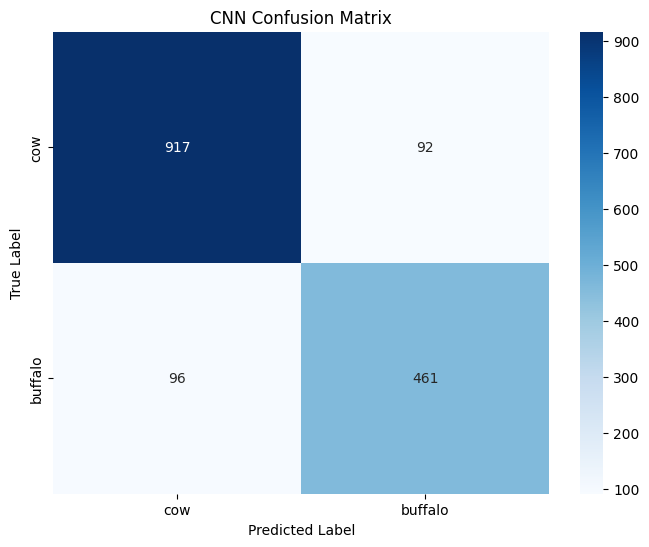

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch

# Set the CNN model to evaluation mode
cnn_model.eval()

# Lists to store true labels and predicted labels for CNN
cnn_all_true_labels = []
cnn_all_predicted_labels = []

# Move CNN model to the device if not already there
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn_model.to(device)

# Disable gradient calculation for evaluation
with torch.no_grad():
    for images, labels in test_loader:
        # Move images and labels to the device
        images, labels = images.to(device), labels.to(device)

        # Forward pass through CNN model
        outputs = cnn_model(images)

        # Get predicted class indices
        _, predicted = torch.max(outputs.data, 1)

        # Append true and predicted labels to the lists
        cnn_all_true_labels.extend(labels.cpu().numpy()) # Move labels back to CPU for scikit-learn
        cnn_all_predicted_labels.extend(predicted.cpu().numpy()) # Move predictions back to CPU

# Calculate Accuracy for CNN
cnn_accuracy = accuracy_score(cnn_all_true_labels, cnn_all_predicted_labels)
print(f"CNN Test Accuracy: {cnn_accuracy:.4f}")

# Generate Classification Report for CNN
# We need the target names (cow, buffalo) corresponding to the integer labels (0, 1)
target_names = ['cow', 'buffalo'] # Ensure this order matches your label_map {'cow': 0, 'buffalo': 1}
print("\nCNN Classification Report:")
print(classification_report(cnn_all_true_labels, cnn_all_predicted_labels, target_names=target_names))

# Generate Confusion Matrix for CNN
cnn_conf_matrix = confusion_matrix(cnn_all_true_labels, cnn_all_predicted_labels)

print("\nCNN Confusion Matrix:")
print(cnn_conf_matrix)

# Visualize Confusion Matrix for CNN
plt.figure(figsize=(8, 6))
sns.heatmap(cnn_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('CNN Confusion Matrix')
plt.show()

In [ ]:
# The content of your Streamlit app (app.py)
# Paste the code I provided previously here
app_py_content = """
import streamlit as st
import torch
import torchvision.transforms as transforms
from PIL import Image
import timm # Assuming you have timm installed in your Streamlit environment

# Define the model architecture (needs to match your Colab code)
def build_vit_model():
    model = timm.create_model('vit_base_patch16_224', pretrained=False) # pretrained=False initially
    num_ftrs = model.head.in_features
    model.head = torch.nn.Linear(num_ftrs, 2)
    return model

# Define the same transformations used for validation/testing
def define_transforms():
    return transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

# Load the trained model
@st.cache_resource # Cache the model loading
def load_my_model(model_path):
    model = build_vit_model()
    # Load the state dictionary
    state_dict = torch.load(model_path, map_location=torch.device('cpu')) # Adjust map_location if using GPU
    model.load_state_dict(state_dict)
    model.eval() # Set to evaluation mode
    return model

# Load your trained model file (assuming it's named 'animal_classifier.pth')
model_path = 'animal_classifier.pth' # Make sure this file is in the same directory or provide the full path
my_model = load_my_model(model_path)
my_transforms = define_transforms()
label_map_inverse = {0: 'Cow', 1: 'Buffalo'} # Inverse of your label_map

st.set_page_config(page_title="Animal Classifier App", layout="wide")

st.title("🐮🐂 Cow and Buffalo Classifier")

st.write("Upload an image of a cow or a buffalo to get a classification prediction.")

uploaded_file = st.file_uploader("Choose an image...", type=["jpg", "jpeg", "png"])

if uploaded_file is not None:
    image = Image.open(uploaded_file).convert('RGB')
    st.image(image, caption="Uploaded Image.", use_column_width=True)
    st.write("")

    # Create a spinner while classifying
    with st.spinner("Classifying..."):
        # Preprocess the image
        image_tensor = my_transforms(image).unsqueeze(0) # Add batch dimension

        # Make prediction
        with torch.no_grad():
            outputs = my_model(image_tensor)
            probabilities = torch.softmax(outputs, dim=1)
            _, predicted_class_index = torch.max(outputs.data, 1)

        predicted_class = label_map_inverse[predicted_class_index.item()]
        confidence = probabilities[0][predicted_class_index].item()

    st.subheader("Classification Result:")
    st.write(f"**Predicted Class:** {predicted_class}")
    st.write(f"**Confidence:** {confidence:.2f}")

    # Optional: Display probabilities for both classes
    st.write("Probabilities:")
    for i, prob in enumerate(probabilities[0]):
        class_name = label_map_inverse[i]
        st.write(f"- {class_name}: {prob.item():.2f}")


st.sidebar.header("About")
st.sidebar.info("This app uses a trained Vision Transformer (ViT) model to classify images as either a cow or a buffalo.")
st.sidebar.write("Created based on a model trained in Google Colab.")

# Footer
st.markdown("---")
st.markdown("Built with ❤️ and Streamlit")
"""

# Define the file name
file_name = "app.py"

# Write the content to the file
with open(file_name, "w") as f:
    f.write(app_py_content)

print(f"'{file_name}' has been saved in your Colab environment.")

'app.py' has been saved in your Colab environment.


In [ ]:
from google.colab import files
import os # Import os to check if the file exists

# Specify the path to the file you want to download
file_to_download = 'app.py'

# Check if the file exists before attempting to download
if os.path.exists(file_to_download):
  files.download(file_to_download)
else:
  print(f"Error: The file {file_to_download} was not found.")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>